<a href="https://colab.research.google.com/github/itchyfeet-patient/Going_Deeper/blob/master/Create_Segmentation_Model_U-Net%2B%2B/%5BGD_4%5DSemantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8-5. 프로젝트 : 개선된 U-Net 모델 만들기** 🕸 🕷 

이번 프로젝트에서는 U-Net을 구현해보고, 그보다 개선된 U-Net ++ 모델을 구현해보겠습니다. U-Net ++ 모델은 upsampling 모델과 Transposed 모델을 각각 만들어 총 세개의 모델을 비교해보겠습니다.  
1. U-Net 구현
2. U-Net ++ (Transpose)
3. U-Net ++ (Upsampling)

---

가장먼저 라이브러리를 불러오고 버전 체크를 해보겠습니다.

In [6]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

from glob import glob
import os
import math
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import keras.backend as K
import keras

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

'''
노드 버전
2.6.0
1.21.4
8.3.2
0.18.3
1.1.0
'''

2.9.2
1.21.6
7.1.2
0.18.3
1.2.1


'\n노드 버전\n2.6.0\n1.21.4\n8.3.2\n0.18.3\n1.1.0\n'

## **Step 1. KITTI 데이터셋 수집과 구축**
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 **배치 사이즈를 적절히 줄여서 설정**하시기를 권합니다.



### **0. Dataset 불러오기** 
지금까지 보던 라벨 데이터와 다르게 세크멘테이션 데이터는 이미지 형태의 라벨로 되어있습니다.

![image](https://user-images.githubusercontent.com/108614874/194515952-373fc53b-aaf6-483c-8be0-16db8217496b.png)  
[KITTI 데이터셋]  
![image](https://user-images.githubusercontent.com/108614874/194515969-41469dda-80e7-4032-9b70-536912e1719c.png)  
[KITTI 데이터셋 segmentation]  
![image](https://user-images.githubusercontent.com/108614874/194515992-bfa4f8b9-3ed2-459d-a89c-c24671258e86.png)  
[KITTI 데이터셋 segmentation_rgb]


라벨이 어떤식으로 주어졌는지 보세요.


```
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

```

우리가 찾을 도로(road)는 7번에 맵핑되어있습니다.

### **1. 데이터 로더 만들기**

입력값, 출력값의 크기를 갖는 모델을 학습시킬 수 있도록 **데이터셋을 파싱**합니다.  
데이터로더에 augmentation을 적용해 봅니다. 파이썬에 많이 사용되는 albumentations 를 사용해봅니다.

In [7]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

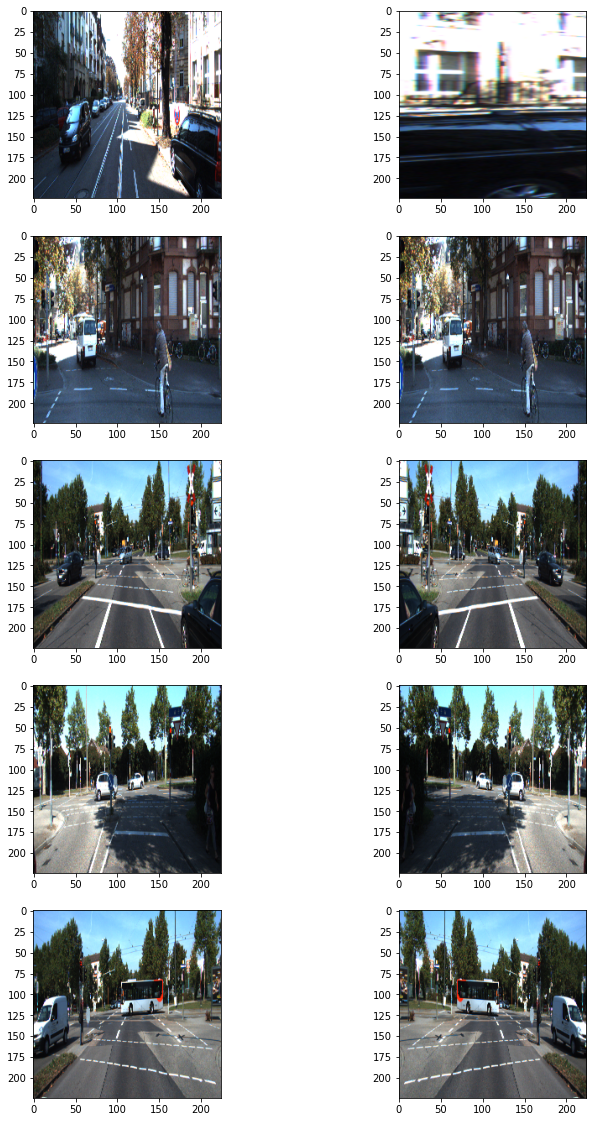

In [8]:
dir_path = '/content/drive/MyDrive/dataset/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봤습니다.

**data loader 만들기**

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1 # 도로 7번!
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## **Step 2. U-Net 모델의 구현**

![image](https://user-images.githubusercontent.com/108614874/194495665-69253a9c-9b19-4523-9279-be3b212c03a2.png)  

### unet

In [29]:
def build_unet(input_shape=(224, 224, 3)):
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.

    inputs = Input(input_shape)
    depth = 64

    # Contracting Path
    # Conv0_0
    conv1 = Conv2D(depth*1, (3,3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth*1, (3,3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(depth*2, (3,3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth*2, (3,3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(depth*4, (3,3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth*4, (3,3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(depth*8, (3,3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(depth*8, (3,3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)

    conv5 = Conv2D(depth*16, (3,3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(depth*16, (3,3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Expanding Path
    drop5 = Dropout(0.5)(conv5)
    upconv6 = Conv2DTranspose(depth*8, (2,2), strides=(2,2), activation='relu')(drop5)

    merge6 = concatenate([drop4,upconv6], axis = 3)
    conv6 = Conv2D(depth*8, (3,3), activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(depth*8, (3,3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    upconv7 = Conv2DTranspose(depth*4, (2,2), strides=(2,2), activation='relu')(conv6)
    merge7 = concatenate([conv3,upconv7], axis = 3)
    conv7 = Conv2D(depth*4, (3,3), activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(depth*4, (3,3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    upconv8 = Conv2DTranspose(depth*2, (2,2), strides=(2,2), activation='relu')(conv7)
    merge8 = concatenate([conv2,upconv8], axis = 3)
    conv8 = Conv2D(depth*2, (3,3), activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(depth*2, (3,3), activation='relu', padding='same')(conv8)    
    conv8 = BatchNormalization()(conv8)

    upconv9 = Conv2DTranspose(depth*1, (2,2), strides=(2,2), activation='relu')(conv8)
    merge9 = concatenate([conv1,upconv9], axis = 3)
    conv9 = Conv2D(depth*1, (3,3), activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(depth*1, (3,3), activation='relu', padding='same')(conv9) 
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1 ,(1,1), activation='sigmoid')(conv9)   


    model = Model(inputs = inputs, outputs = conv10)
    return model

In [30]:
unet = build_unet()
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_78 (BatchN  (None, 224, 224, 64  256        ['conv2d_21[0][0]']              
 ormalization)                  )                                                           

In [31]:

model_path = '/content/drive/MyDrive/dataset/semantic_segmentation/seg_model_unet.h5'

model = build_unet()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy') # 논문에서 적혀있던 대로 crossentropy를 씁니당.
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.


Epoch 1/100
22/22 [==============================] - 16s 509ms/step - loss: 0.7108 - val_loss: 0.6675
Epoch 2/100
22/22 [==============================] - 9s 392ms/step - loss: 0.6613 - val_loss: 0.6382
Epoch 3/100
22/22 [==============================] - 9s 395ms/step - loss: 0.6231 - val_loss: 0.6123
Epoch 4/100
22/22 [==============================] - 9s 397ms/step - loss: 0.5611 - val_loss: 0.5747
Epoch 5/100
22/22 [==============================] - 9s 399ms/step - loss: 0.5553 - val_loss: 0.5378
Epoch 6/100
22/22 [==============================] - 9s 399ms/step - loss: 0.5822 - val_loss: 0.4871
Epoch 7/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4791 - val_loss: 0.4454
Epoch 8/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4322 - val_loss: 0.4073
Epoch 9/100
22/22 [==============================] - 9s 403ms/step - loss: 0.3840 - val_loss: 0.3539
Epoch 10/100
22/22 [==============================] - 9s 404ms/step - loss: 0.3744 - val_l

이미 실습단계에서 unet은 학습시킨 모델이 있기 때문에 저장한 파일을 불러와서 사용했습니다.

## **Step 3. U-Net++ 모델의 구현**
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

![image](https://user-images.githubusercontent.com/108614874/194898182-e3d7395c-8494-40b5-be43-eb74b86718d5.png)


참고할 수 있는 코드는 아래에 있습니다. 다행히도 keras로 구현되어 있습니다.

[U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus)  
코드 중에서 가장 중요한 부분도 알려드리자면 [여기:build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)입니다. 논문에서 제시하는 수식과 함께 참고하세요.

![image](https://user-images.githubusercontent.com/108614874/194898458-c2bf454a-43a1-4988-bff9-214d4a142595.png)  

H와 u와 '[ ]'가 무엇인지 주목하세요(https://arxiv.org/pdf/1807.10165.pdf)

코드 중 `up_block`으로는 두 가지 방식을 사용하고 있네요.  
[Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53)과 [Upsample2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28)인데요. 둘 중 어느 것을 사용해도 좋습니다.

또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점입니다. binary cross-entropy와 dice coefficient를 사용한다고 하는데요. [dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고해 보세요.

![image](https://user-images.githubusercontent.com/108614874/194898986-13afff0d-4a1f-44a3-8fd6-b1c71b1d5e5b.png)  
[binary cross-entropy와 dice coefficient를 이용합니다](https://arxiv.org/pdf/1807.10165.pdf)


---   
  
  
**👻 정리**  
1. Transpose2D_block과 Upsample2D_block 중 하나 사용하면 되지만 난 둘다 만들어볼거에요
2. binary cross-entropy와 dice coefficient를 더한 DiceBCE loss를 사용할거에요
3. 논문에서 설명된 구조 참고해서 만들거에요

---

#### DiceBCELoss 함수

In [13]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


구현한 모델을 그림으로 한 번 그려봤습니다.  
downsampling과 upsampling은 unet과 동일하지만 conv6부터는 upsampling된 conv layer + skip connection들의 조합으로 이뤄져있습니다.  
그 점만 주의하면 쉽게 구현할 수 있었습니다. 

![image](https://user-images.githubusercontent.com/108614874/195790161-88dd6170-b70f-405c-806e-04c66b5cf467.png)


본격적으로 u-net++을 만들어봅니다. 앞서 말했듯 transpose 버전과 upsample버전을 각각 만들어 비교해보겠습니다.

### **☝ U-net++ (transpose)**

In [14]:
def build_unet_plus_trans(input_shape=(224,224,3)):
    inputs = Input(input_shape)
    depth = [64, 128, 256, 512, 1024]

    # Contracting Path
    # conv1
    conv1 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv1_1')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv1_2')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    # conv2
    conv2 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv2_1')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv2_2')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    # conv3
    conv3 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv3_1')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv3_2')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    # conv4
    conv4 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv4_1')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv4_2')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)


    # conv5
    conv5 = Conv2D(depth[4], (3,3), activation='relu', padding='same',name='conv5_1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(depth[4], (3,3), activation='relu', padding='same',name='conv5_2')(conv5)
    conv5 = BatchNormalization()(conv5)
    # drop5 = Dropout(0.5)(conv5)


    # Expanding Path
    # conv6
    upconv6 = Conv2DTranspose(depth[0], (2,2), strides=(2,2), activation='relu')(conv2)
    merge6 = concatenate([conv1,upconv6], axis = 3)

    conv6 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv6_1')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv6_2')(conv6)
    conv6 = BatchNormalization()(conv6)

    # conv7
    upconv7 = Conv2DTranspose(depth[1], (2,2), strides=(2,2), activation='relu')(conv3)
    merge7 = concatenate([conv2,upconv7], axis = 3)
    
    conv7 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv7_1')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv7_2')(conv7)
    conv7 = BatchNormalization()(conv7)

    # conv8
    upconv8 = Conv2DTranspose(depth[2], (2,2), strides=(2,2), activation='relu')(conv4)
    merge8 = concatenate([conv3,upconv8], axis = 3)
    
    conv8 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv8_1')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv8_2')(conv8)
    conv8 = BatchNormalization()(conv8)

    # conv9
    upconv9 = Conv2DTranspose(depth[3], (2,2), strides=(2,2), activation='relu')(conv5)
    merge9 = concatenate([conv4,upconv9], axis = 3)
    
    conv9 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv9_1')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv9_2')(conv9)
    conv9 = BatchNormalization()(conv9)

    # conv10
    upconv10 = Conv2DTranspose(depth[0], (2,2), strides=(2,2), activation='relu')(conv7)
    merge10 = concatenate([conv1, conv6, upconv10], axis = 3)
    
    conv10 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv10_1')(merge10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv10_2')(conv10)
    conv10 = BatchNormalization()(conv10)

    # conv11
    upconv11 = Conv2DTranspose(depth[1], (2,2), strides=(2,2), activation='relu')(conv8)
    merge11 = concatenate([conv2, conv7, upconv11], axis = 3)
    
    conv11 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv11_1')(merge11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv11_2')(conv11)
    conv11 = BatchNormalization()(conv11)

    # conv12
    upconv12 = Conv2DTranspose(depth[2], (2,2), strides=(2,2), activation='relu')(conv9)
    merge12 = concatenate([conv3, conv8, upconv12], axis = 3)
    
    conv12 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv12_1')(merge12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv12_2')(conv12)
    conv12 = BatchNormalization()(conv12)

    # conv13
    upconv13 = Conv2DTranspose(depth[0], (2,2), strides=(2,2), activation='relu')(conv11)
    merge13 = concatenate([conv1, conv6, conv10, upconv13], axis = 3)
    
    conv13 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv13_1')(merge13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv13_2')(conv13)
    conv13 = BatchNormalization()(conv13)

    # conv14
    upconv14 = Conv2DTranspose(depth[1], (2,2), strides=(2,2), activation='relu')(conv12)
    merge14 = concatenate([conv2, conv7, conv11, upconv14], axis = 3)
    
    conv14 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv14_1')(merge14)
    conv14 = BatchNormalization()(conv14)
    conv14 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv14_2')(conv14)
    conv14 = BatchNormalization()(conv14)

    # conv15
    upconv15 = Conv2DTranspose(depth[0], (2,2), strides=(2,2), activation='relu')(conv14)
    merge15 = concatenate([conv1, conv6, conv10, conv13, upconv15], axis = 3)
    
    conv15 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv15_1')(merge15)
    conv15 = BatchNormalization()(conv15)
    conv15 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv15_2')(conv15)
    conv15 = BatchNormalization()(conv15)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv15)
    model = Model(inputs = inputs, outputs = outputs)

    return model

In [15]:
unet_plus_trans = build_unet_plus_trans()
unet_plus_trans.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv1_1[0][0]']                
 ormalization)                  )                                                           

In [108]:
model_path = '/content/drive/MyDrive/dataset/semantic_segmentation/unet_plus_trans.h5'

model = unet_plus_trans
model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss) # bce dice loss 사용!
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.


Epoch 1/100
22/22 [==============================] - 54s 2s/step - loss: 0.2788 - val_loss: 0.2667
Epoch 2/100
22/22 [==============================] - 23s 1s/step - loss: 0.2046 - val_loss: 0.2645
Epoch 3/100
22/22 [==============================] - 23s 1s/step - loss: 0.2033 - val_loss: 0.2585
Epoch 4/100
22/22 [==============================] - 24s 1s/step - loss: 0.1837 - val_loss: 0.2512
Epoch 5/100
22/22 [==============================] - 24s 1s/step - loss: 0.0987 - val_loss: 0.1978
Epoch 6/100
22/22 [==============================] - 23s 1s/step - loss: 0.1125 - val_loss: 0.1492
Epoch 7/100
22/22 [==============================] - 23s 1s/step - loss: 0.0929 - val_loss: 0.0864
Epoch 8/100
22/22 [==============================] - 23s 1s/step - loss: 0.0437 - val_loss: -0.0811
Epoch 9/100
22/22 [==============================] - 23s 1s/step - loss: 0.0695 - val_loss: 7.9164e-04
Epoch 10/100
22/22 [==============================] - 23s 1s/step - loss: 0.0775 - val_loss: -0.0428
Epo

### ✌ U-net++ (upsample)

In [16]:
def build_unet_plus_up(input_shape=(224,224,3)):
    inputs = Input(input_shape)
    depth = [64, 128, 256, 512, 1024]

    # Contracting Path
    # conv1
    conv1 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv1_1')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv1_2')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    # conv2
    conv2 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv2_1')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv2_2')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    # conv3
    conv3 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv3_1')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv3_2')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    # conv4
    conv4 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv4_1')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv4_2')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)


    # conv5
    conv5 = Conv2D(depth[4], (3,3), activation='relu', padding='same',name='conv5_1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(depth[4], (3,3), activation='relu', padding='same',name='conv5_2')(conv5)
    conv5 = BatchNormalization()(conv5)
    # drop5 = Dropout(0.5)(conv5)
   

    
    # Expanding Path
    # conv6
    upconv6 = UpSampling2D()(conv2)
    merge6 = concatenate([conv1,upconv6], axis = 3)

    conv6 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv6_1')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv6_2')(conv6)
    conv6 = BatchNormalization()(conv6)

    # conv7
    upconv7 = UpSampling2D()(conv3)
    merge7 = concatenate([conv2,upconv7], axis = 3)
    
    conv7 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv7_1')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv7_2')(conv7)
    conv7 = BatchNormalization()(conv7)

    # conv8
    upconv8 = UpSampling2D()(conv4)
    merge8 = concatenate([conv3,upconv8], axis = 3)
    
    conv8 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv8_1')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv8_2')(conv8)
    conv8 = BatchNormalization()(conv8)

    # conv9
    upconv9 = UpSampling2D()(conv5)
    merge9 = concatenate([conv4,upconv9], axis = 3)
    
    conv9 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv9_1')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(depth[3], (3,3), activation='relu', padding='same',name='conv9_2')(conv9)
    conv9 = BatchNormalization()(conv9)

    # conv10
    upconv10 = UpSampling2D()(conv7)
    merge10 = concatenate([conv1, conv6, upconv10], axis = 3)
    
    conv10 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv10_1')(merge10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv10_2')(conv10)
    conv10 = BatchNormalization()(conv10)

    # conv11
    upconv11 = UpSampling2D()(conv8)
    merge11 = concatenate([conv2, conv7, upconv11], axis = 3)
    
    conv11 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv11_1')(merge11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv11_2')(conv11)
    conv11 = BatchNormalization()(conv11)

    # conv12
    upconv12 = UpSampling2D()(conv9)
    merge12 = concatenate([conv3, conv8, upconv12], axis = 3)
    
    conv12 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv12_1')(merge12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(depth[2], (3,3), activation='relu', padding='same',name='conv12_2')(conv12)
    conv12 = BatchNormalization()(conv12)

    # conv13
    upconv13 = UpSampling2D()(conv11)
    merge13 = concatenate([conv1, conv6, conv10, upconv13], axis = 3)
    
    conv13 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv13_1')(merge13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv13_2')(conv13)
    conv13 = BatchNormalization()(conv13)

    # conv14
    upconv14 = UpSampling2D()(conv12)
    merge14 = concatenate([conv2, conv7, conv11, upconv14], axis = 3)
    
    conv14 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv14_1')(merge14)
    conv14 = BatchNormalization()(conv14)
    conv14 = Conv2D(depth[1], (3,3), activation='relu', padding='same',name='conv14_2')(conv14)
    conv14 = BatchNormalization()(conv14)

    # conv15
    upconv15 = UpSampling2D()(conv14)
    merge15 = concatenate([conv1, conv6, conv10, conv13, upconv15], axis = 3)
    
    conv15 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv15_1')(merge15)
    conv15 = BatchNormalization()(conv15)
    conv15 = Conv2D(depth[0], (3,3), activation='relu', padding='same',name='conv15_2')(conv15)
    conv15 = BatchNormalization()(conv15)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv15)
    model = Model(inputs = inputs, outputs = outputs)

    return model

In [17]:
unet_plus_up = build_unet_plus_up()
unet_plus_up.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 224, 224, 64  256        ['conv1_1[0][0]']                
 ormalization)                  )                                                           

In [23]:
model_path = '/content/drive/MyDrive/dataset/semantic_segmentation/unet_plus_up.h5'

model = unet_plus_up
model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss) # bce dice loss 사용!
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.


Epoch 1/100
22/22 [==============================] - 51s 2s/step - loss: 0.2669 - val_loss: 0.2711
Epoch 2/100
22/22 [==============================] - 23s 1s/step - loss: 0.1892 - val_loss: 0.2677
Epoch 3/100
22/22 [==============================] - 23s 1s/step - loss: 0.1578 - val_loss: 0.4903
Epoch 4/100
22/22 [==============================] - 23s 1s/step - loss: 0.0933 - val_loss: 0.2037
Epoch 5/100
22/22 [==============================] - 23s 1s/step - loss: 0.0657 - val_loss: 0.2741
Epoch 6/100
22/22 [==============================] - 23s 1s/step - loss: 0.0765 - val_loss: 0.0518
Epoch 7/100
22/22 [==============================] - 24s 1s/step - loss: 0.0493 - val_loss: -0.0282
Epoch 8/100
22/22 [==============================] - 24s 1s/step - loss: 0.0846 - val_loss: -0.0789
Epoch 9/100
22/22 [==============================] - 24s 1s/step - loss: 0.0618 - val_loss: -0.0772
Epoch 10/100
22/22 [==============================] - 24s 1s/step - loss: 0.0101 - val_loss: -0.0372
Epoch

## **Step 4. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석**
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

IoU를 계산하는 함수와 시각화함수를 만들어줍니다.

In [18]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [35]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    plt.imshow(output)
    plt.show()
    #output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [20]:
work_path = '/content/drive/MyDrive/dataset/semantic_segmentation'

### **🚕 U-Net**

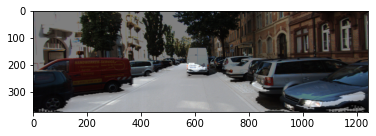

IoU : 0.610672


0.6106717389128041

In [40]:
model_path = work_path + '/seg_model_unet.h5' 
model = tf.keras.models.load_model(model_path)
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png' )

unet_iou = calculate_iou_score(target, prediction)
unet_iou

차인데 도로로 잘못 인식한 경우가 눈에 띕니다.

### **🚗 U-Net++ (Transpose2D_block 사용)**

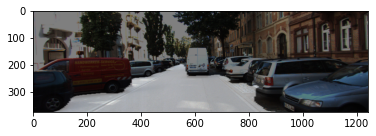

IoU : 0.708660


0.7086595769545402

In [38]:
model_path = work_path + '/unet_plus_trans.h5' 
model = tf.keras.models.load_model(model_path, custom_objects={ 'bce_dice_loss': bce_dice_loss })
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png' )

trans_iou = calculate_iou_score(target, prediction)
trans_iou

확실히 u-net과 비교하면 차를 도로로 잘못 인식하는 경우가 덜했습니다.

### **🚙 U-Net++ (Upsample2D_block 사용)**

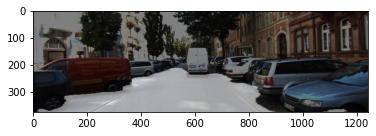

IoU : 0.672322


0.6723220226214238

In [41]:
model_path = work_path + '/unet_plus_up.h5' 
model = tf.keras.models.load_model(model_path, custom_objects={ 'bce_dice_loss': bce_dice_loss })
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png' )

up_iou = calculate_iou_score(target, prediction)
up_iou

transpose block을 사용했을 때보다는 IoU가 낮지만 u-net보다는 높습니다.

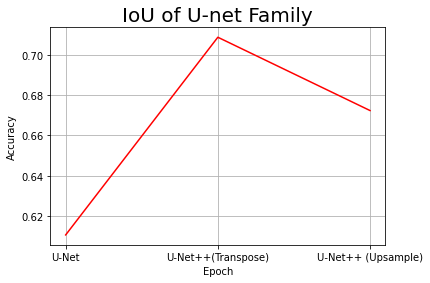

In [59]:
g = unet_iou, trans_iou, up_iou
x = [0, 1, 2]
plt.plot(x, g, 'r')

values = ['U-Net', 'U-Net++(Transpose)', 'U-Net++ (Upsample)']

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('IoU of U-net Family', size=20)

plt.grid(True)
plt.xticks(x,values)
plt.show()

IoU 값으로 시각화 한 모습입니다.  
U-Net << U-Net++ (Upsample) << U-Net++ (Transpose)  를 잘 보여줍니다.

---

### **🍟 루브릭**  
| 평가문항 | 상세기준 | 학습결과 |
|:---:|:---:|:---:|
| 1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가? | KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다. | O |
| 2. U-Net++ 모델이 성공적으로 구현되었는가? | U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다. | O |
| 3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? | U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다. | O |

### **✍ 회고**

* `BCE_DICE_LOSS`를 사용하니 `BCE`를 사용할 때보다 사용량이 늘어났다. Batch_Size를 16->8 로 줄여줬다. 같은 모델임에도 loss function을 바꾸니 계산량이 늘어난 것인가? 오래걸렸다.
* 모델학습을 덮어씌워버려서 아쉽지만.. `BCE`(Binary Cross Entropy)를 사용했을 때보다 `BCE Dice loss`를 사용했을 때 경계부분을 더 잘 구분했음을 알 수 있었다. (기억조작일수도 있음..)
* `keras`에는 dice loss function이 없어서 `bce dice loss function`을 custom loss function으로 만들어서 쓴건데, `model load`가 안되는 문제가 있었다. stackoverflow의 도움으로 해결했당.
* 예상했던 결과가 그대로 나와서 즐겁게 했다. 

* `unet++`에서 `UpSampling2D` 모델보다 `Conv2DTranspose` 모델이 더 IoU가 높게 나왔는데 왜일까?
    * 내 생각에는 upsampling은 단순히 픽셀? 이미지를 늘려서 이미지를 크게 하는건데 transpose는 필터를 설정해주는 걸로 보아 일반적인 convolution layer처럼 학습을 하면서 이미지 크기를 키우는거라 조금 더 똑똑한 메커니즘이라는 생각이 든다.  

    관련 내용을 찾아보니 [What is the difference between UpSampling2D and Conv2DTranspose functions in keras?](https://stackoverflow.com/questions/53654310/what-is-the-difference-between-upsampling2d-and-conv2dtranspose-functions-in-ker) 에서 이런 의견이 있었다.

    >**UpSampling2D** is just a simple scaling up of the image by using nearest neighbour or bilinear upsampling, so nothing smart. Advantage is it's cheap.  
    >**Conv2DTranspose** is a convolution operation whose kernel is learnt (just like normal conv2d operation) while training your model. Using Conv2DTranspose will also upsample its input but the key difference is the model should learn what is the best upsampling for the job.

* 실습때부터 U-Net과 U-Net++을 직접 구현해 볼 수 있었다. 예시로 첨부되어있던 github의 코드처럼 멋지고 사용하기 편하게 구현하지는 못했지만 내 손으로 직접 했다는 점에 큰 의의를 뒀다. (+ 그리고 돌아가는 코드라는 것에 !!)
* U-Net ++ 구현 모식도를 처음 봤을 때는 `이걸 어떻게 내가 구현..?` 이라는 생각이 들었는데, 논문의 식만 보고 지레 겁먹은 것이었다 ㅎ 뭐니뭐니해도 그림을 그려서 정리하니 수월하게 해낼 수 있었다.

#### **📚 참고문헌**

* [U-Net 참고](https://hiwony.tistory.com/entry/MNIST-unet)
* [U_Net++ 참고](https://medium.com/@codecompose/unet-480d378906fd)
* [bce_dice_loss 참고](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)
* [custom loss function 사용시 model load 안되는 문제 참고](https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras)
* [Dice 와 IoU의 차이점 정리](https://ballentain.tistory.com/m/80)